## CNN For Text Classification

Train a CNN on a dataset of labelled toxic (1) and non-toxic (0) comments (train dataset) and use the model to classify a test dataset of comments as either toxic or non-toxic. 

This model uses the keras library and we compared our metrics with those returned by the CNN model created using PyTorch and a simple baseline bag of words model. For consistency and a fair comparison, we applied the same pre-processing functions to the data for all models. 

Reference:
https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe
from itertools import combinations
import torch
import os
import time
from sklearn.metrics import classification_report

In [150]:
# file_path = '/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project/train.csv'
# df = pd.read_csv(file_path)
# df.head()

In [2]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Toxic and non-toxic first

Dealing with imbalanced data. Keep all 15294 rows for toxic comments and 16000 rows from non-toxic comments

In [152]:
# # filter for only non-toxic comments 
# non_toxic_df = df[df['toxic'] == 0]

# # randomly sample 16000 rows from this dataframe 
# non_toxic_df_sample = non_toxic_df.sample(n=16000, random_state=42)

# # get only the rows with toxic comments 
# toxic_df = df[df['toxic'] == 1]

# # concat both dataframes and shuffle the rows 
# comment_df = pd.concat([non_toxic_df_sample, toxic_df])
# comment_df = comment_df.sample(frac=1).reset_index(drop=True)
# comment_df


In [153]:
# plt.hist(comment_df['toxic'])
# plt.show()

In [154]:
# Read in balanced dataset 

data_path = '/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project/balanced_data.csv'
df = pd.read_csv(data_path)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,length,word_count
0,1b7fe21f6b20f176,The Wack Pack \n\nYou're fucking insane and dr...,1,0,1,0,1,0,220,37
1,2b77b61ee27ab6fb,Not according to Wikipedia policy. With respec...,0,0,0,0,0,0,77,11
2,626d12d910b34c40,"You just revert my and a lot of peoples work, ...",1,0,1,0,1,0,222,39
3,2ed8095b9ee464b0,"Frank O'Hara, Anti-Beat? \nSeriously, dude, yo...",0,0,0,0,0,0,544,93
4,86f8607fd0572b9f,"""\n\nreverting\nUser:Baristarim decides that t...",0,0,0,0,0,0,440,72


In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


### Tokenize using keras

In [156]:
MAX_SENT_LENGTH = 200
BATCH_SIZE = 16
EMBEDDING_DIM = 300

In [157]:
# load balanced data

# df = df[df["word_count"] <= MAX_SENT_LENGTH]
# df = df.reset_index(drop=True)
# df = df[["comment_text", "toxic"]]
# df.head(5)

In [158]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [159]:
import tensorflow as tf
print(tf.__version__)

2.11.1


In [160]:
sentences = df['comment_text'].values
y = df['toxic'].values
sentences

array(["The Wack Pack \n\nYou're fucking insane and drunk with power. Instead of totally removing big Howard Stern guys like Crackhead Bob and Fred the Elephant Boy, why not just remove the parts that your majesty finds offensive?",
       'Not according to Wikipedia policy. With respect 99.231.50.255  Pavel Golikov.',
       "You just revert my and a lot of peoples work, to improve wiki. So you're a motherfucker. How dare you block an user or users, just because he or she reverted your destructive activite. Shame on you.\nShitface Anna Frodesiak",
       ...,
       'The Criticism section \n\nThe way the criticism section reads at the time of this writing is quite okay, in my opinion. It brings up the most important, on point criticisms of the mainstream in a very readable, well sourced manner, without superfluous ad hominem comments. It also include a reasonable level of Austrian responses to the criticisms. In my view, there is no need for any further changes.\n\nThe Mises-slur is, 

In [161]:
# sentences_train, sentences_test, y_train, y_test = train_test_split(
#                                                 sentences, y,  
#                                                 test_size=0.25,  
#                                                 random_state=42)

# Create a train, validate and test dataset 
# train 70%, validation 20%, test 10%

X_train, X_rest, y_train, y_rest = train_test_split(sentences, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.33, random_state=1)

print("train:", len(X_train), "validation:", len(X_val), "test", len(X_test))



train: 21411 validation: 6148 test 3029


In [162]:
# Preprocess the data

NUM_WORDS = 10000

# Using max_len = 200 for consistency 
MAX_LEN = 200

tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
# maxlen = max([len(x) for x in X_train])
# 325
# print(f"X_train max len: {maxlen}")
X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LEN)
X_val = pad_sequences(X_val, padding='post', maxlen=MAX_LEN)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LEN)

In [163]:
# Adding 1 because of  reserved 0 index
# vocab_size = len(tokenizer.word_index) + 1
# vocab_size = len(tokenizer.word_index)

# maxlen = 100

# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Create Embedding Matrix 


Using pre-tarined embeddings from GloVe

In [164]:
# VECTOR_CACHE_DIR = '/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project'

# glove = GloVe(name='6B', cache = VECTOR_CACHE_DIR)
glove = GloVe(name='6B')


words = ["hello", "hi", "king", "president"]
vecs = glove.get_vecs_by_tokens(words)

In [165]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size = len(word_index) + 1 
    # Adding 1 because of reserved 0 index
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    # Load the pre-trained GloVe embeddings
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = coefs

    return embedding_matrix

In [166]:
# vocab_size = len(word_index) 

# embedding_matrix = np.zeros((vocab_size, 300))
# embedding_matrix

In [167]:
EMBEDDING_DIM = 300
glove_filename = 'glove.6B.300d.txt'
glove_filepath = '/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project/glove.6B'
glove_filepath_final = os.path.join(glove_filepath, glove_filename)

word_index = tokenizer.word_index

embedding_matrix = create_embedding_matrix(glove_filepath_final, word_index, EMBEDDING_DIM)



In [168]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [169]:
# Use keras to define the model architecture of the CNN

FILTERS= 64
KERNEL_SIZE=5
ACTIVATION='relu'
ACTIVATION_LAST='sigmoid'
VOCAB_SIZE = len(word_index)+1
DROPOUT = 0.5
UNITS_FIRST = 64
UNITS_SECOND = 1


model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],input_length=MAX_LEN, trainable=False))
model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=UNITS_FIRST, activation=ACTIVATION))
model.add(Dropout(DROPOUT))
model.add(Dense(units=UNITS_SECOND, activation=ACTIVATION_LAST))


In [170]:
# Compile the model

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [171]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 300)          16449300  
                                                                 
 conv1d_3 (Conv1D)           (None, 196, 64)           96064     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                      

In [172]:
# Train the model
EPOCHS = 50

start_time = time.time()
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE)

print(f'Time taken to complete all {EPOCHS} epochs: {time.time() - start_time} seconds')

Epoch 1/50
1339/1339 [==============================] - 20s 15ms/step - loss: 0.2919 - accuracy: 0.8783 - val_loss: 0.2489 - val_accuracy: 0.8943
Epoch 2/50
1339/1339 [==============================] - 22s 16ms/step - loss: 0.2132 - accuracy: 0.9154 - val_loss: 0.2477 - val_accuracy: 0.8987
Epoch 3/50
1339/1339 [==============================] - 18s 14ms/step - loss: 0.1653 - accuracy: 0.9374 - val_loss: 0.2755 - val_accuracy: 0.8988
Epoch 4/50
1339/1339 [==============================] - 17s 13ms/step - loss: 0.1232 - accuracy: 0.9539 - val_loss: 0.2991 - val_accuracy: 0.8980
Epoch 5/50
1339/1339 [==============================] - 18s 14ms/step - loss: 0.0874 - accuracy: 0.9685 - val_loss: 0.4556 - val_accuracy: 0.8837
Epoch 6/50
1339/1339 [==============================] - 17s 13ms/step - loss: 0.0628 - accuracy: 0.9772 - val_loss: 0.4518 - val_accuracy: 0.8824
Epoch 7/50
1339/1339 [==============================] - 17s 13ms/step - loss: 0.0517 - accuracy: 0.9829 - val_loss: 0.5094 -

In [173]:
# Get prediction metrics

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

95/95 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1510
           1       0.91      0.89      0.90      1519

    accuracy                           0.90      3029
   macro avg       0.90      0.90      0.90      3029
weighted avg       0.90      0.90      0.90      3029



670/670 [==============================] - 7s 10ms/step - loss: 0.0019 - accuracy: 0.9991
Training Accuracy: 0.9991
Validation Accuracy:  0.8904
Testing Accuracy:  0.9000


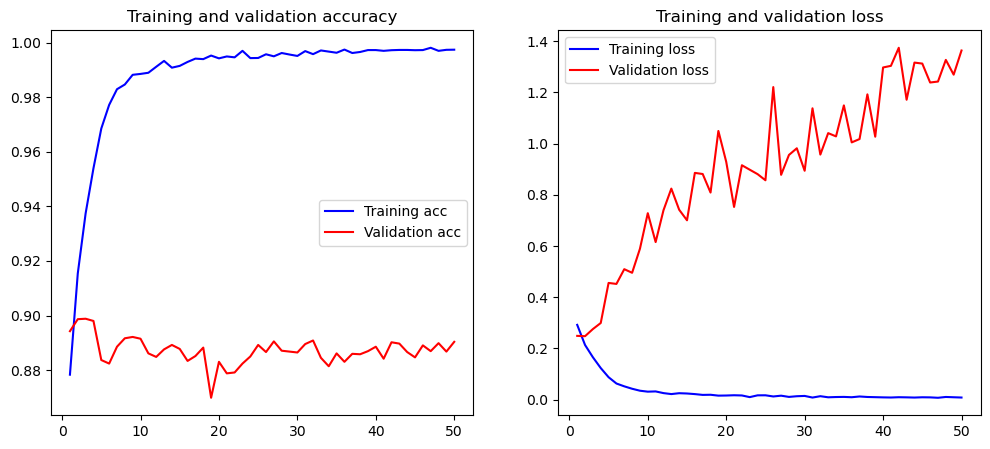

In [176]:
# Plot results 

loss_train, accuracy_train = model.evaluate(X_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy_train))
loss_val, accuracy_val = model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy_val))
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))
plot_history(history)

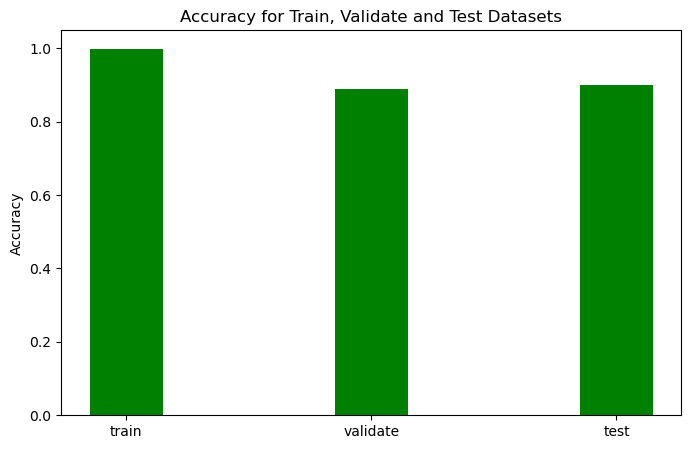

In [185]:
acc_dict = {'train': accuracy_train, 'validate':accuracy_val, 'test':accuracy_test}
x_ = list(acc_dict.keys())
values = list(acc_dict.values())

  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(x_, values, color ='green',
        width = 0.3)
 
# plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.title("Accuracy for Train, Validate and Test Datasets")
plt.show()

In [ ]:
## SAVE THE MODEL TO DISK ##

model.save("model1_50epochs.h5")
print("Saved model to disk")

## Use the model to test on unseen comment data from the youtube comments dataset

In [ ]:
# test load the model 
# from tensorflow.keras.models import load_model
# # load model
# model = load_model('model.h5')
# # print summary
# model.summary()